In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression # IMN Placeholder
# from sklearn.neural_network import MLPClassifier # Alternative IMN Placeholder (ensure it has predict_proba)
from sklearn.metrics import roc_auc_score # Changed from accuracy_score
from sklearn.preprocessing import LabelEncoder
# from sklearn.inspection import permutation_importance # Option for MLP importance

# --- Model Libraries ---
import catboost
from pytorch_tabnet.tab_model import TabNetClassifier
import shap

# --- Plotting ---
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression # IMN Placeholder
from sklearn.neural_network import MLPClassifier # Alternative IMN Placeholder
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import permutation_importance # Option for MLP importance

# --- Model Libraries ---
import catboost
from pytorch_tabnet.tab_model import TabNetClassifier
import shap

# --- Plotting ---
import matplotlib.pyplot as plt

# --- Helper Function for Normalizing Importances ---

2. Splitting data...


In [ ]:
# --- Helper Function for Normalizing Importances (no changes needed here) ---
def get_ranked_features(importances, feature_names):
    """Returns feature names ranked by importance."""
    if importances is None:
        print("Warning: Received None for importances.")
        return []

    try:
        # Ensure importances is treated as a flat numpy array
        importances_flat = np.array(importances).flatten()

        if len(importances_flat) == 0:
             print("Warning: Received empty importances.")
             return []
        if len(importances_flat) != len(feature_names):
             print(f"Warning: Mismatch between importances length ({len(importances_flat)}) and feature_names length ({len(feature_names)}).")
             return [] # Return empty for safety.

        abs_importances = np.abs(importances_flat)
        indices = np.argsort(abs_importances)[::-1]

        # Explicitly cast index 'i' to a standard Python int
        ranked_list = [feature_names[int(i)] for i in indices]
        return ranked_list

    except IndexError as e:
        print(f"Error during indexing in get_ranked_features: {e}")
        print(f"  Indices generated (first 10): {indices[:10]}")
        print(f"  Length of feature_names: {len(feature_names)}")
        return [] # Return empty list on error
    except Exception as e:
        print(f"An unexpected error occurred in get_ranked_features: {e}")
        print(f"  Importances type: {type(importances)}, Shape: {np.array(importances).shape if hasattr(importances, 'shape') else 'N/A'}")
        return [] # Return empty list on error


In [ ]:
# --- Loading data ---

df = pd.read_csv("/home/athyrson/Code/Data/Processed Data/Lending Club/df_2010.csv")

X = df.drop(columns=['target'])
y = df['target']

# --- 2. Split Data ---
print("2. Splitting data...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [ ]:


# Define preprocessing for numerical and categorical features
numerical_features = X.select_dtypes(include=['float64', 'int64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Preprocessing for numerical data: Impute missing values and scale
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
]).set_output(transform='pandas')

# Preprocessing for categorical data: Impute missing values and apply target encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('target', TargetEncoder())
]).set_output(transform='pandas')

# Combine preprocessors in a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
).set_output(transform='pandas')

# Apply preprocessing to the training and test data
X_train = preprocessor.fit_transform(X_train, y_train)
X_test = preprocessor.transform(X_test)

feature_names = X_train.columns.to_list()
feature_names

# Ensure y is integer encoded if needed by models like TabNet
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)


3&4. Training base models, getting baseline accuracy and importances...
  Processing: DecisionTree
    Baseline Accuracy: 0.8206
    Top 5 Features: ['num__last_fico_range_low', 'num__annual_inc', 'cat__earliest_cr_line', 'num__dti', 'cat__addr_state']
  Processing: CatBoost
    Baseline Accuracy: 0.8772
    Top 5 Features: ['num__last_fico_range_low', 'num__last_fico_range_high', 'num__annual_inc', 'cat__addr_state', 'cat__zip_code']
  Processing: TabNet

Early stopping occurred at epoch 45 with best_epoch = 35 and best_val_0_auc = 0.86329


/home/athyrson/Code/py10/lib64/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


    Baseline Accuracy: 0.8764
    Top 5 Features: ['num__last_fico_range_low', 'num__last_fico_range_high', 'num__int_rate', 'num__out_prncp', 'num__acc_now_delinq']
  Processing: IMN_Placeholder_LR
    Baseline Accuracy: 0.8772
    Top 5 Features: ['cat__purpose', 'num__last_fico_range_high', 'num__funded_amnt_inv', 'cat__sub_grade', 'num__funded_amnt']

4b. Calculating SHAP importances (on Decision Tree)...
    Top 5 SHAP Features: []

5&6. Evaluating performance drop after removing top 5 features...
  Processing removal analysis for: DecisionTree
    Removing Top-1 feature: num__last_fico_range_low
      New Accuracy: 0.8219, Drop: -0.0013
    Removing Top-2 feature: num__annual_inc
      New Accuracy: 0.8142, Drop: 0.0064
    Removing Top-3 feature: cat__earliest_cr_line
      New Accuracy: 0.8227, Drop: -0.0021
    Removing Top-4 feature: num__dti
      New Accuracy: 0.8232, Drop: -0.0027
    Removing Top-5 feature: cat__addr_state
      New Accuracy: 0.8142, Drop: 0.0064
  Proces

/home/athyrson/Code/py10/lib64/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


      New Accuracy: 0.8663, Drop: 0.0101
    Removing Top-2 feature: num__last_fico_range_high

Early stopping occurred at epoch 23 with best_epoch = 13 and best_val_0_auc = 0.86262


/home/athyrson/Code/py10/lib64/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


      New Accuracy: 0.8679, Drop: 0.0085
    Removing Top-3 feature: num__int_rate

Early stopping occurred at epoch 41 with best_epoch = 31 and best_val_0_auc = 0.86209


/home/athyrson/Code/py10/lib64/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


      New Accuracy: 0.8729, Drop: 0.0035
    Removing Top-4 feature: num__out_prncp

Early stopping occurred at epoch 39 with best_epoch = 29 and best_val_0_auc = 0.86164


/home/athyrson/Code/py10/lib64/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


      New Accuracy: 0.8743, Drop: 0.0021
    Removing Top-5 feature: num__acc_now_delinq

Early stopping occurred at epoch 20 with best_epoch = 10 and best_val_0_auc = 0.85617


/home/athyrson/Code/py10/lib64/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


      New Accuracy: 0.8666, Drop: 0.0098
  Processing removal analysis for: IMN_Placeholder_LR
    Removing Top-1 feature: cat__purpose
      New Accuracy: 0.8756, Drop: 0.0016
    Removing Top-2 feature: num__last_fico_range_high
      New Accuracy: 0.8724, Drop: 0.0048
    Removing Top-3 feature: num__funded_amnt_inv
      New Accuracy: 0.8753, Drop: 0.0019
    Removing Top-4 feature: cat__sub_grade
      New Accuracy: 0.8769, Drop: 0.0003
    Removing Top-5 feature: num__funded_amnt
      New Accuracy: 0.8783, Drop: -0.0011
  Processing removal analysis for: SHAP (DecisionTree)
    Skipping SHAP (DecisionTree) due to missing importance ranking.

7. Summary of Accuracy Drops:

Method              | Rank | Accuracy Drop
--------------------|------|---------------
DecisionTree        |  1   | -0.0013
DecisionTree        |  2   | 0.0064
DecisionTree        |  3   | -0.0021
DecisionTree        |  4   | -0.0027
DecisionTree        |  5   | 0.0064
CatBoost            |  1   | 0.0058
CatBoo

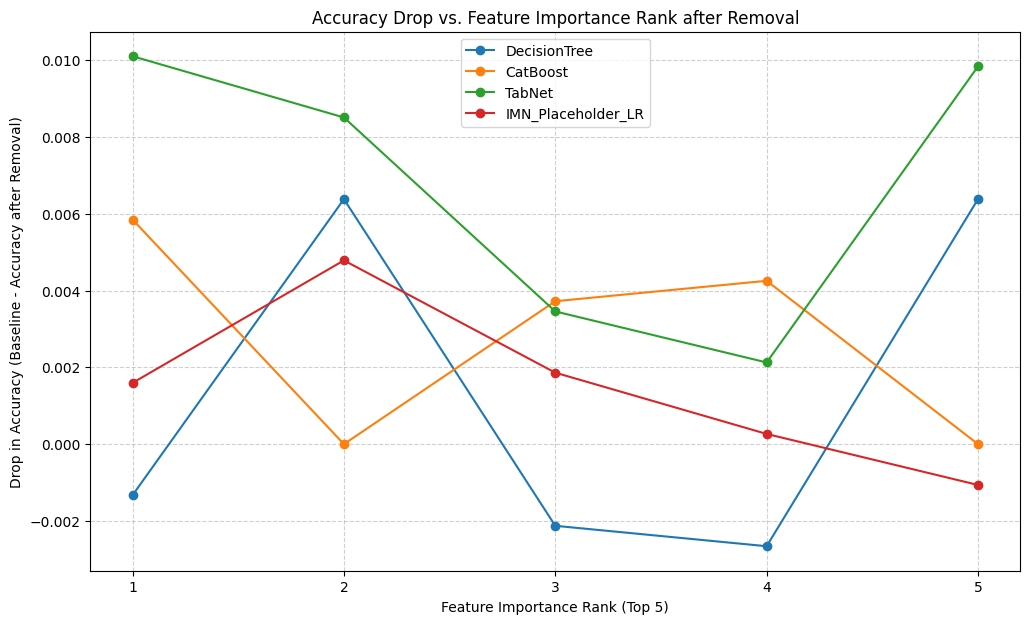


Analysis complete. Check the plot to visually compare the monotonicity of accuracy drop.


In [ ]:

# --- Models and Importance Methods ---
models_to_evaluate = {
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "CatBoost": catboost.CatBoostClassifier(verbose=0, random_state=42),
    "TabNet": TabNetClassifier(verbose=0, seed=42),
    # Replace with actual IMN model if available
    "IMN_Placeholder_LR": LogisticRegression(random_state=42, max_iter=1000),
    # SHAP will be calculated separately on one of the models (e.g., DecisionTree)
}

# Store results: {method_name: [baseline_acc, {rank: acc_drop}]}
results = {}
top_n_features = 5

# --- 3 & 4. Train Base Models, Get Baseline Accuracy & Importances ---
print("\n3&4. Training base models, getting baseline accuracy and importances...")

feature_importances = {} # {method_name: [ranked_feature_list]}

for name, model in models_to_evaluate.items():
    print(f"  Processing: {name}")

    # Handle TabNet's specific input requirements if necessary (often accepts numpy)
    if name == "TabNet":
        # TabNet needs eval_set for potential early stopping/metrics
        model.fit(X_train.values, y_train,
                  eval_set=[(X_test.values, y_test)],
                  patience=10, # Example early stopping parameter
                  max_epochs=50) # Limit epochs for speed
    else:
        model.fit(X_train, y_train)

    y_pred = model.predict(X_test if name != "TabNet" else X_test.values)
    baseline_acc = accuracy_score(y_test, y_pred)
    results[name] = {'baseline_acc': baseline_acc, 'drops': {}}

    # Get Importances
    imps = None
    ranked_features = []
    if name == "DecisionTree":
        imps = model.feature_importances_
        ranked_features = get_ranked_features(imps, feature_names)
    elif name == "CatBoost":
        imps = model.get_feature_importance()
        ranked_features = get_ranked_features(imps, feature_names)
    elif name == "TabNet":
        # TabNet importance might need care - check documentation for exact method
        # Using feature_importances_ attribute here
        imps = model.feature_importances_
        ranked_features = get_ranked_features(imps, feature_names)
    elif name == "IMN_Placeholder_LR":
        # Using absolute coefficient values for LR placeholder
        if hasattr(model, 'coef_'):
           imps = model.coef_[0] # Assuming binary classification
           ranked_features = get_ranked_features(imps, feature_names)


    feature_importances[name] = ranked_features
    print(f"    Baseline Accuracy: {baseline_acc:.4f}")
    if ranked_features:
       print(f"    Top {top_n_features} Features: {ranked_features[:top_n_features]}")
    else:
       print(f"    Could not retrieve feature importances.")


# --- 4b. Calculate SHAP Importances (Example on Decision Tree) ---
print("\n4b. Calculating SHAP importances (on Decision Tree)...")
dt_model = models_to_evaluate["DecisionTree"]
explainer = shap.TreeExplainer(dt_model, X_train) # Use training data for explainer background
shap_values = explainer.shap_values(X_test) # Calculate SHAP for test set

# For classification, shap_values might be a list (one per class)
# Use mean abs SHAP value across all classes or for the positive class
if isinstance(shap_values, list):
    # Sum absolute values across samples and potentially classes
    # For binary classification, shap_values[1] often relates to the positive class
    shap_sum = np.abs(shap_values[1]).mean(axis=0)
else:
     # For regression or single-output models
    shap_sum = np.abs(shap_values).mean(axis=0)

shap_ranked_features = get_ranked_features(shap_sum, feature_names)
feature_importances["SHAP (DecisionTree)"] = shap_ranked_features
results["SHAP (DecisionTree)"] = {'baseline_acc': results["DecisionTree"]['baseline_acc'], 'drops': {}} # Use DT baseline
print(f"    Top {top_n_features} SHAP Features: {shap_ranked_features[:top_n_features]}")


# --- 5 & 6. Iterative Feature Removal and Evaluation ---
print(f"\n5&6. Evaluating performance drop after removing top {top_n_features} features...")

all_methods = list(models_to_evaluate.keys()) + ["SHAP (DecisionTree)"]

for method_name in all_methods:
    print(f"  Processing removal analysis for: {method_name}")

    if method_name not in feature_importances or not feature_importances[method_name]:
        print(f"    Skipping {method_name} due to missing importance ranking.")
        continue

    ranked_features = feature_importances[method_name]
    baseline_acc = results[method_name]['baseline_acc']

    # Determine which base model type to use for retraining
    if "SHAP" in method_name:
        model_to_retrain = DecisionTreeClassifier(random_state=42) # Retrain the model SHAP explained
    elif "IMN_Placeholder_LR" in method_name:
         model_to_retrain = LogisticRegression(random_state=42, max_iter=1000)
    elif "TabNet" in method_name:
         model_to_retrain = TabNetClassifier(verbose=0, seed=42)
    elif "CatBoost" in method_name:
         model_to_retrain = catboost.CatBoostClassifier(verbose=0, random_state=42)
    else: # Default to Decision Tree if base model name matches
        model_to_retrain = DecisionTreeClassifier(random_state=42)


    # Ensure we don't try to remove more features than available
    num_features_to_remove = min(top_n_features, len(ranked_features))

    for k in range(1, num_features_to_remove + 1):
        feature_to_remove = ranked_features[k-1]
        print(f"    Removing Top-{k} feature: {feature_to_remove}")

        # Create reduced datasets
        X_train_reduced = X_train.drop(columns=[feature_to_remove], axis = 1)
        X_test_reduced = X_test.drop(columns=[feature_to_remove], axis = 1)

        # Retrain model
        if isinstance(model_to_retrain, TabNetClassifier):
            # Handle TabNet specific input if necessary
            model_to_retrain.fit(X_train_reduced.values, y_train,
                                 eval_set=[(X_test_reduced.values, y_test)],
                                 patience=10, max_epochs=50) # Retrain TabNet
            y_pred_reduced = model_to_retrain.predict(X_test_reduced.values)
        else:
            model_to_retrain.fit(X_train_reduced, y_train)
            y_pred_reduced = model_to_retrain.predict(X_test_reduced)


        # Evaluate and calculate drop
        acc_reduced = accuracy_score(y_test, y_pred_reduced)
        acc_drop = baseline_acc - acc_reduced
        results[method_name]['drops'][k] = acc_drop
        print(f"      New Accuracy: {acc_reduced:.4f}, Drop: {acc_drop:.4f}")

# --- 7. Analyze Results ---
print("\n7. Summary of Accuracy Drops:")

# Prepare data for plotting
plot_data = {}
ranks = list(range(1, top_n_features + 1))

print("\nMethod              | Rank | Accuracy Drop")
print("--------------------|------|---------------")
for method, data in results.items():
    if not data['drops']: # Handle cases where importance/drops weren't calculated
        print(f"{method:<20}|  -   | N/A")
        continue

    plot_data[method] = []
    for k in ranks:
       drop = data['drops'].get(k, np.nan) # Use NaN if rank wasn't processed
       plot_data[method].append(drop)
       print(f"{method:<20}|  {k}   | {drop:.4f}")


# --- Optional: Plotting the results (like Figure 6 description) ---
plt.figure(figsize=(12, 7))
for method, drops in plot_data.items():
    # Plot only if there are valid drop values
    valid_ranks = [r for r, d in zip(ranks, drops) if not np.isnan(d)]
    valid_drops = [d for d in drops if not np.isnan(d)]
    if valid_ranks:
       plt.plot(valid_ranks, valid_drops, marker='o', linestyle='-', label=method)

plt.xlabel(f"Feature Importance Rank (Top {top_n_features})")
plt.ylabel("Drop in Accuracy (Baseline - Accuracy after Removal)")
plt.title("Accuracy Drop vs. Feature Importance Rank after Removal")
plt.xticks(ranks)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

print("\nAnalysis complete. Check the plot to visually compare the monotonicity of accuracy drop.")